# 플랜
## 1. 전처리
1. 이상치 제거
2. 차원축소
    1. feature selection
        - 'c_15'
        - 'c_16'
        - 'c_15','c_16'
    2. PCA 할 feature 선택 \
       여러 feature를 선형조합하여 잠재변수(latent variable)를 만들 수 있다면 선택 가능
       - 사고관련 feature
4. 더미화
    - 샘플링과 더미화 split의 순서가?
    - Q)더미화를 하고 샘플링을 하면 카테고리 데이터가 오염될 수 있지 않은가?
3. train_test_split
    - 샘플링 전에 나눠져야 하는데?
3. sampling (oversampling)
    - SMOTE
    - ADASYM
    - RandomOverSampling

## 2. 학습
여러번 할거니 함수를 만들면서 해보자
1. 모델 고르기
2. 성능평가
3. 학습
3. CV
4. pipeline ?
    
## 3. try
1. 조건을 바꿔가며 시도
2. 함수 개선?

### TODO : 
- `c_6` 를 numeric으로 쓸 수 있을지 검토
- `c_9 == 0`은 날려보자

In [2]:
df = pd.read_csv('../../datas/fraud_detect_data_encoded.csv')
df.shape

(16000, 25)

# -- Base --

## 1. 전처리

### 1-1. 이상치 제거

In [ ]:
## None

### 1-2. 차원축소
#### feature selection

In [ ]:
## None

#### PCA

In [ ]:
## None

### 1-3. train test split

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
def split_train_test(df):
    train_set = df[df['c_25'] == 0]
    test_set = df[df['c_25'] == 1]

    X_train = train_set.drop(['c_25','c_1'], axis=1)
    y_train = train_set['c_1']

    X_test = test_set.drop(['c_25', 'c_1'], axis=1)
    y_test = test_set['c_1']
    
    print('get train test split!')
    print('y_train : ', list(map(lambda x: x.tolist(),np.unique(y_train, return_counts=True))))
    print('y_test :', list(map(lambda x: x.tolist(),np.unique(y_test, return_counts=True))) )

    return X_train, X_test, y_train, y_test

In [5]:
X_train, X_test, y_train, y_test = split_train_test(df)

get train test split!
y_train :  [[0, 1], [12845, 34]]
y_test : [[0, 1], [3114, 7]]


### 1-3. sampling

In [ ]:
## None

### 1-4. dummy

In [6]:
def dummy_train_test(X_train, X_test, features=None):
    X_train_1hot = pd.get_dummies(X_train, columns=features)
    X_test_1hot = pd.get_dummies(X_test, columns=features)
    
    print('get dummies!')
    print('X_train : ', X_train_1hot.shape)
    print('X_test : ', X_test_1hot.shape)
    
    return X_train_1hot, X_test_1hot

In [7]:
features = df.columns.drop(['c_1', 'c_8', 'c_15', 'c_16', 'c_20', 'c_25'])
X_train_1hot, X_test_1hot = dummy_train_test(X_train, X_test, features=features)

get dummies!
X_train :  (12879, 75)
X_test :  (3121, 75)


## 2. 학습

### 2-1. model
- Logistic Regression
- Decision Tree
- Random Forest
- LightGBM

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

In [9]:
models = [('LogisticReg', LogisticRegression(random_state=13, solver='liblinear')),
          ('DecisionTree', DecisionTreeClassifier(random_state=13, max_depth=4)),
          ('RandomForest', RandomForestClassifier(random_state=13, n_jobs=-1, n_estimators=100)),
          ('LightGBM', LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False))]

model_names = [model[0] for model in models]
model_names

['LogisticReg', 'DecisionTree', 'RandomForest', 'LightGBM']

### 2-2. 성능평가

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

In [11]:
def get_clf_eval(y_test, pred):
    acc = accuracy_score(y_test, pred)
    pre = precision_score(y_test, pred)
    rec = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    auc = roc_auc_score(y_test, pred)
    
    return acc, pre, rec, f1, auc

def print_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    acc, pre, rec, f1, auc = get_clf_eval(y_test, pred)
    
    print('=> confusion matrix')
    print(confusion)
    print('======================')
    
    print('Accurary: {0:.4f}, Precision: {1:.4f}'.format(acc, pre))
    print('Recall: {0:.4f}, F1: {1:.4f}, AUC:{2: .4f}'.format(rec, f1, auc))
    
def get_result(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    
    return get_clf_eval(y_test, pred)

def get_result_pd(models, model_names, X_train, y_train, X_test, y_test):
    col_names = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    tmp = []
    
    for model in models:
        tmp.append(get_result(model[1], X_train, y_train, X_test, y_test))
        
    return pd.DataFrame(tmp, columns=col_names, index=model_names)

### 2-3. 학습

In [12]:
import time

from sklearn.metrics import roc_curve

In [13]:
def draw_roc_curve(models, model_names, X_test, y_test):
    plt.figure(figsize=(10,10))
    
    for idx in range(len(models)):
        pred = models[idx][1].predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, pred)
        plt.plot(fpr, tpr, label=model_names[idx])
        
    plt.plot([0,1], [0,1], 'k--', label='random quess')
    plt.title('ROC')
    plt.legend()
    plt.grid()
    plt.show()

def fit_model(models, model_names, X_train, y_train, X_test, y_test):
    """
    models : models
    model_names : model_names
    X_train : X_train
    y_train : y_train
    X_test : X_test
    y_train : y_train
    """
    
    st_time = time.time()

    results = get_result_pd(models, model_names, X_train, y_train, X_test, y_test)

    print('Finish fitting!')
    print('Fit time :', time.time() - st_time)
    print('<Results>')
    print(results)
    draw_roc_curve(models, model_names, X_test, y_test)

/Users/dockyum/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dockyum/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dockyum/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finish fitting!
Fit time : 1.2619941234588623
<Results>
              accuracy  precision  recall   f1   roc_auc
LogisticReg   0.997757        0.0     0.0  0.0  0.500000
DecisionTree  0.997116        0.0     0.0  0.0  0.499679
RandomForest  0.997757        0.0     0.0  0.0  0.500000
LightGBM      0.997757        0.0     0.0  0.0  0.500000


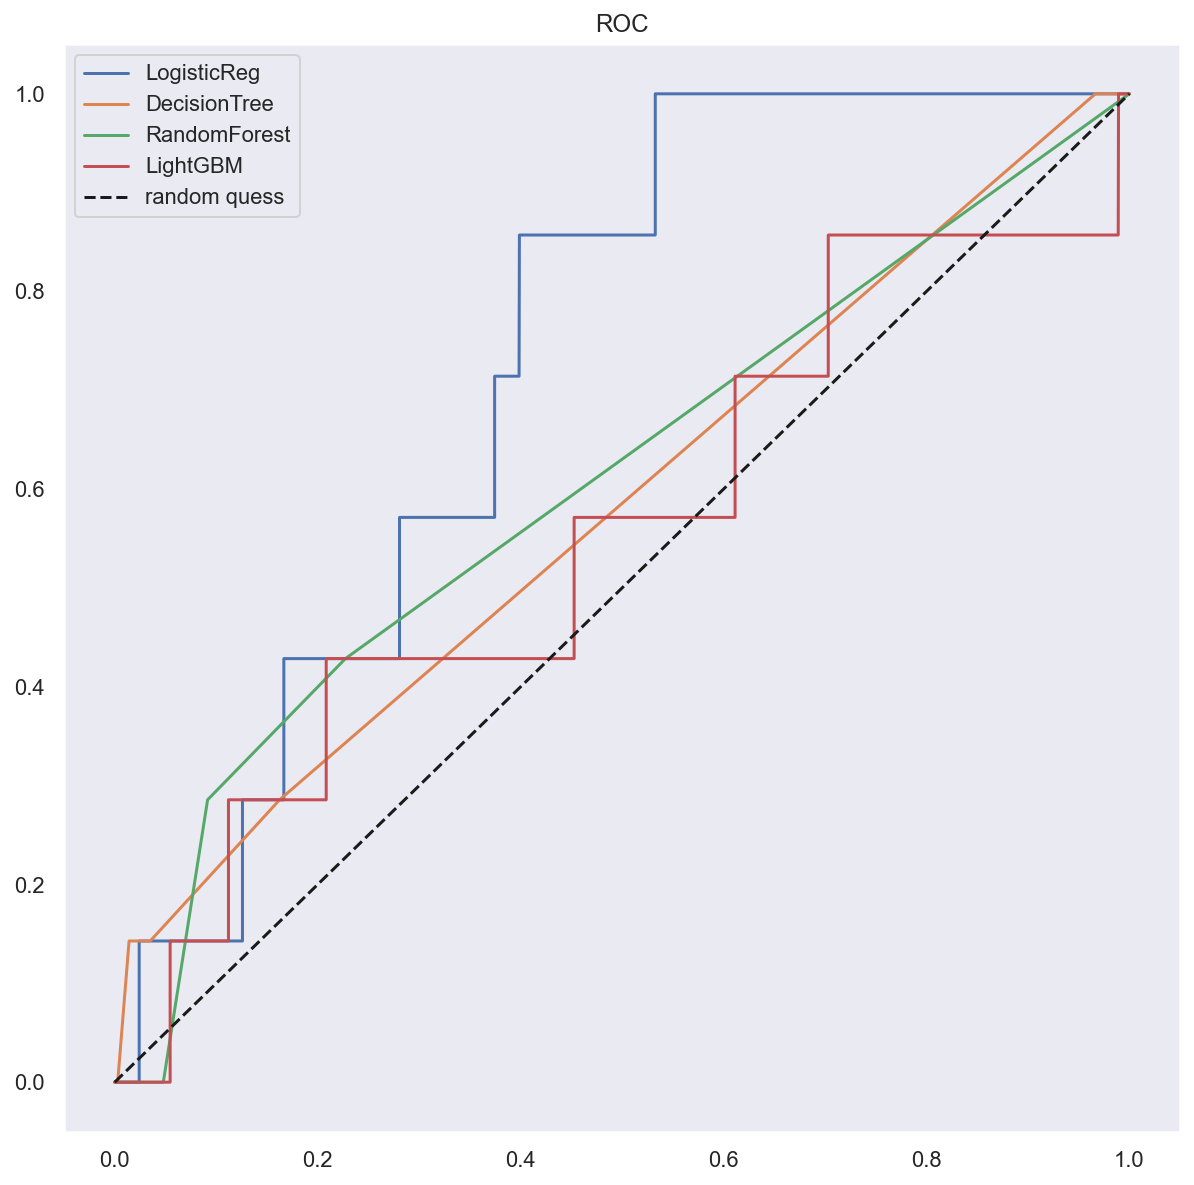

In [14]:
fit_model(models, model_names, X_train_1hot, y_train, X_test_1hot, y_test)

# ==> try-1
RandomOverSampling

## 1. 전처리

### 1-1. 이상치 제거

In [ ]:
## None

### 1-2. 차원축소
#### feature selection

In [ ]:
## None

#### PCA

In [ ]:
## None

### 1-3. train test split

In [15]:
X_train, X_test, y_train, y_test = split_train_test(df)

get train test split!
y_train :  [[0, 1], [12845, 34]]
y_test : [[0, 1], [3114, 7]]


### 1-3. sampling

In [16]:
from imblearn.over_sampling import RandomOverSampler

In [17]:
ROS = RandomOverSampler(random_state=13)
X_train_over, y_train_over = ROS.fit_resample(X_train, y_train)
np.unique(y_train_over, return_counts=True)

(array([0, 1]), array([12845, 12845]))

In [18]:
X_train.shape, y_train.shape

((12879, 23), (12879,))

In [19]:
X_train_over.shape, y_train_over.shape

((25690, 23), (25690,))

### 1-4. dummy

In [20]:
features = df.columns.drop(['c_1', 'c_8', 'c_15', 'c_16', 'c_20', 'c_25'])
X_train_over_1hot, X_test_over_1hot = dummy_train_test(X_train_over, X_test, features=features)

get dummies!
X_train :  (25690, 75)
X_test :  (3121, 75)


## 2. 학습

### 2-1. model
- Logistic Regression
- Decision Tree
- Random Forest
- LightGBM

### 2-2. 성능평가
- get_clf_eval
- print_clf_eval
- get_result
- get_result_pd

### 2-3. 학습

/Users/dockyum/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dockyum/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finish fitting!
Fit time : 1.5294561386108398
<Results>
              accuracy  precision    recall        f1   roc_auc
LogisticReg   0.071772   0.002410  1.000000  0.004809  0.534843
DecisionTree  0.742390   0.002497  0.285714  0.004950  0.514566
RandomForest  0.997757   0.000000  0.000000  0.000000  0.500000
LightGBM      0.997757   0.000000  0.000000  0.000000  0.500000


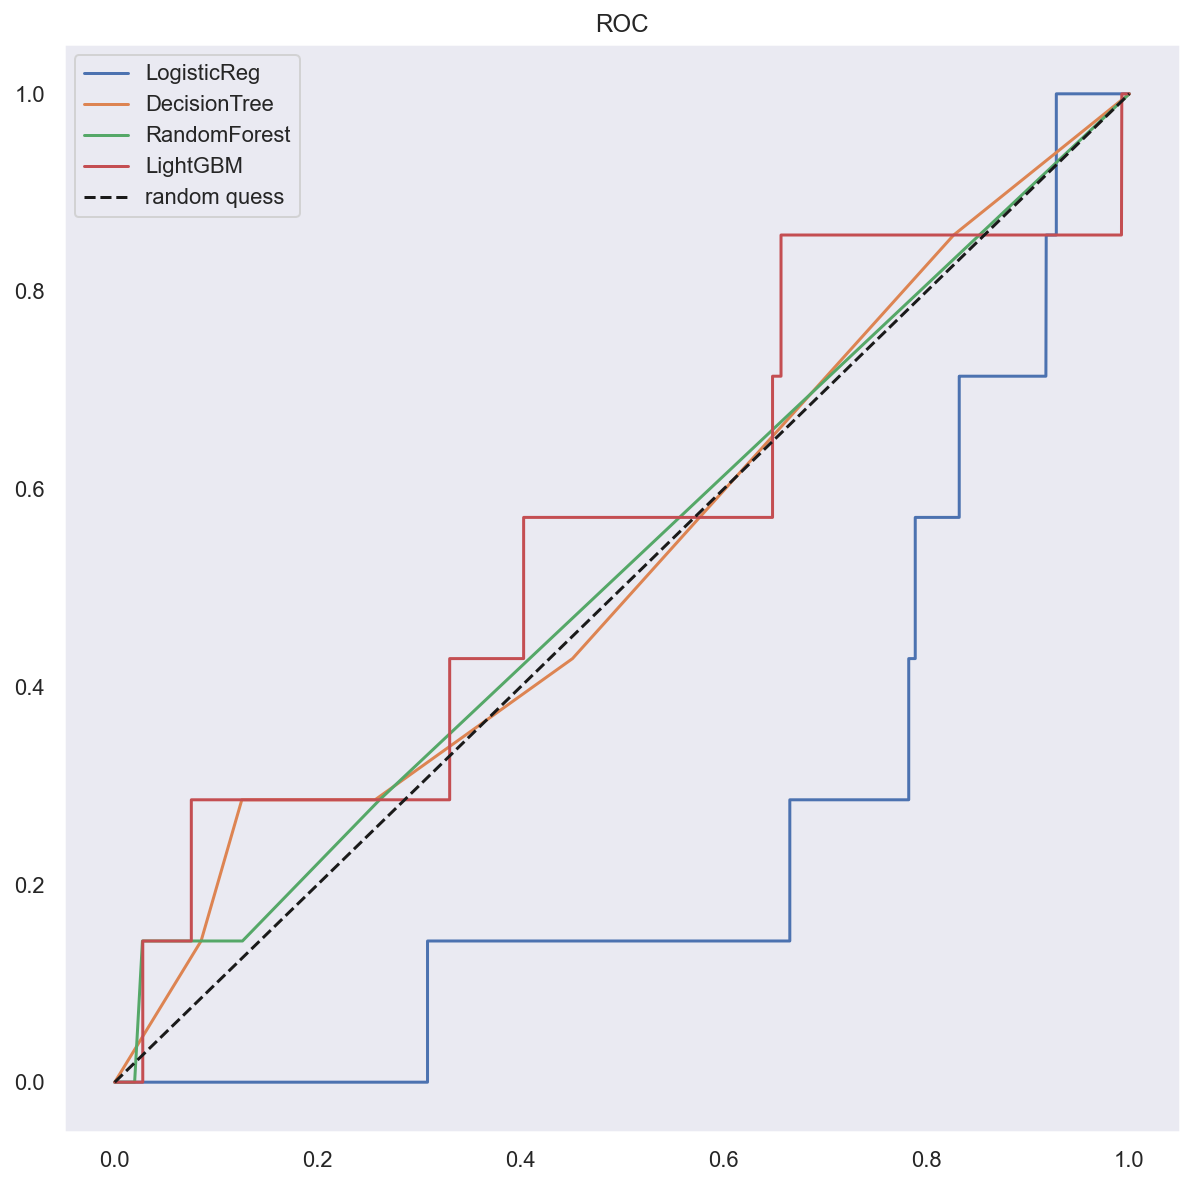

In [21]:
fit_model(models, model_names, X_train_over_1hot, y_train_over, X_test_over_1hot, y_test)

# ==> try-2
sampling : SMOTE

## 1. 전처리

### 1-1. 이상치 제거

In [ ]:
## None

### 1-2. 차원축소
#### feature selection

In [ ]:
## None

#### PCA

In [ ]:
## None

### 1-3. train test split

In [22]:
X_train, X_test, y_train, y_test = split_train_test(df)

get train test split!
y_train :  [[0, 1], [12845, 34]]
y_test : [[0, 1], [3114, 7]]


### 1-3. sampling

In [23]:
from imblearn.over_sampling import SMOTE

In [24]:
SAMPLER = SMOTE(random_state=13)
X_train_over, y_train_over = SAMPLER.fit_resample(X_train, y_train)
np.unique(y_train_over, return_counts=True)

(array([0, 1]), array([12845, 12845]))

In [25]:
X_train.shape, y_train.shape

((12879, 23), (12879,))

In [26]:
X_train_over.shape, y_train_over.shape

((25690, 23), (25690,))

### 1-4. dummy

In [27]:
features = df.columns.drop(['c_1', 'c_8', 'c_15', 'c_16', 'c_20', 'c_25'])
X_train_over_1hot, X_test_1hot = dummy_train_test(X_train_over, X_test, features=features)

get dummies!
X_train :  (25690, 75)
X_test :  (3121, 75)


## 2. 학습

### 2-1. model
- Logistic Regression
- Decision Tree
- Random Forest
- LightGBM

### 2-2. 성능평가
- get_clf_eval
- print_clf_eval
- get_result
- get_result_pd

### 2-3. 학습

Finish fitting!
Fit time : 2.3497729301452637
<Results>
              accuracy  precision    recall        f1   roc_auc
LogisticReg   0.848446   0.000000  0.000000  0.000000  0.425177
DecisionTree  0.697853   0.002128  0.285714  0.004224  0.492247
RandomForest  0.997437   0.000000  0.000000  0.000000  0.499839
LightGBM      0.992631   0.000000  0.000000  0.000000  0.497431


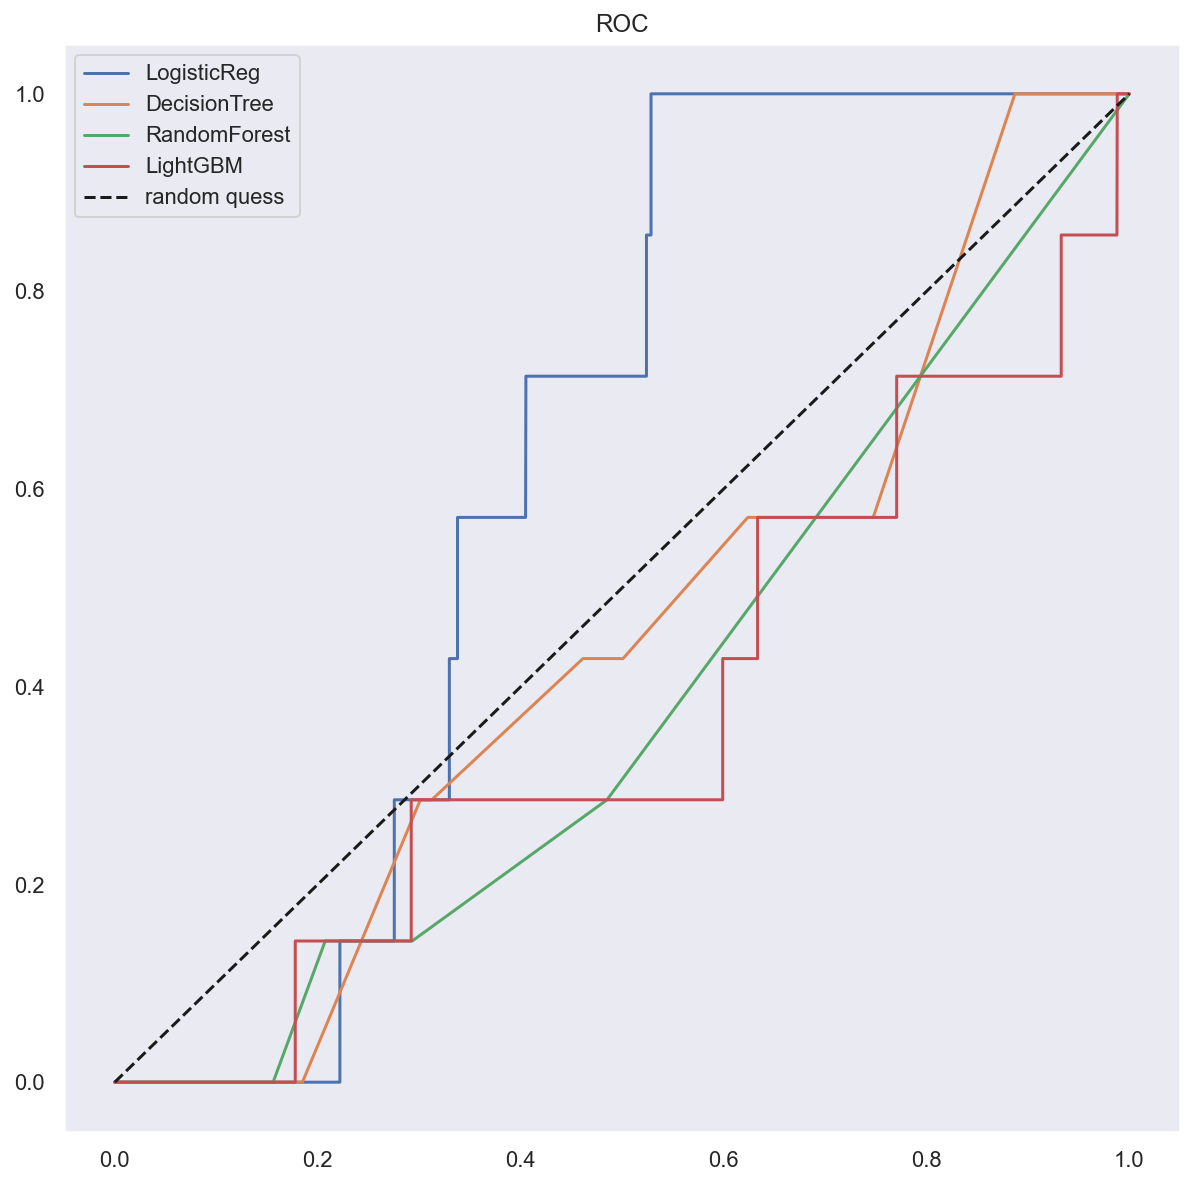

In [28]:
fit_model(models, model_names, X_train_over_1hot, y_train_over, X_test_1hot, y_test)

# ==> try-3
drop feature : 'c_24' , 'c_23', 'c_22', 'c_15', 'c_16' \
sampling : SMOTE

## 1. 전처리

### 1-1. 이상치 제거

In [ ]:
## None

### 1-2. 차원축소
#### feature selection

In [29]:
df_selected = df.drop(['c_24' , 'c_23', 'c_22', 'c_15', 'c_16'], axis=1)
df_selected.shape

(16000, 20)

#### PCA

In [30]:
## None

### 1-3. train test split

In [31]:
X_train, X_test, y_train, y_test = split_train_test(df_selected)

get train test split!
y_train :  [[0, 1], [12845, 34]]
y_test : [[0, 1], [3114, 7]]


### 1-3. sampling

In [32]:
from imblearn.over_sampling import SMOTE

In [33]:
SAMPLER = SMOTE(random_state=13)
X_train_over, y_train_over = SAMPLER.fit_resample(X_train, y_train)
np.unique(y_train_over, return_counts=True)

(array([0, 1]), array([12845, 12845]))

In [34]:
X_train.shape, y_train.shape

((12879, 18), (12879,))

In [35]:
X_train_over.shape, y_train_over.shape

((25690, 18), (25690,))

### 1-4. dummy

In [36]:
def dummy_selected(df, X_train, X_test):
    """
    df : df to get_dummies
    X_train : 
    X_test : 
    """
    cat_features = ['c_2', 'c_3', 'c_4',
           'c_7', 'c_9', 'c_12','c_13', 'c_14',
           'c_17', 'c_21', 'c_22', 'c_23',
           'c_24']

    dum_features = [feature for feature in cat_features if feature in list(df.columns)]

    X_train_dummy, X_test_dummy = dummy_train_test(X_train, X_test, features=dum_features)
    return X_train_dummy, X_test_dummy

In [37]:
X_train_over_d, X_test_d = dummy_selected(df_selected, X_train_over, X_test)

get dummies!
X_train :  (25690, 53)
X_test :  (3121, 53)


## 2. 학습

### 2-1. model
- Logistic Regression
- Decision Tree
- Random Forest
- LightGBM

### 2-2. 성능평가
- get_clf_eval
- print_clf_eval
- get_result
- get_result_pd

### 2-3. 학습

Finish fitting!
Fit time : 2.422456979751587
<Results>
              accuracy  precision    recall       f1   roc_auc
LogisticReg   0.852291   0.000000  0.000000  0.00000  0.427103
DecisionTree  0.607177   0.002449  0.428571  0.00487  0.518075
RandomForest  0.995194   0.000000  0.000000  0.00000  0.498715
LightGBM      0.993592   0.000000  0.000000  0.00000  0.497913


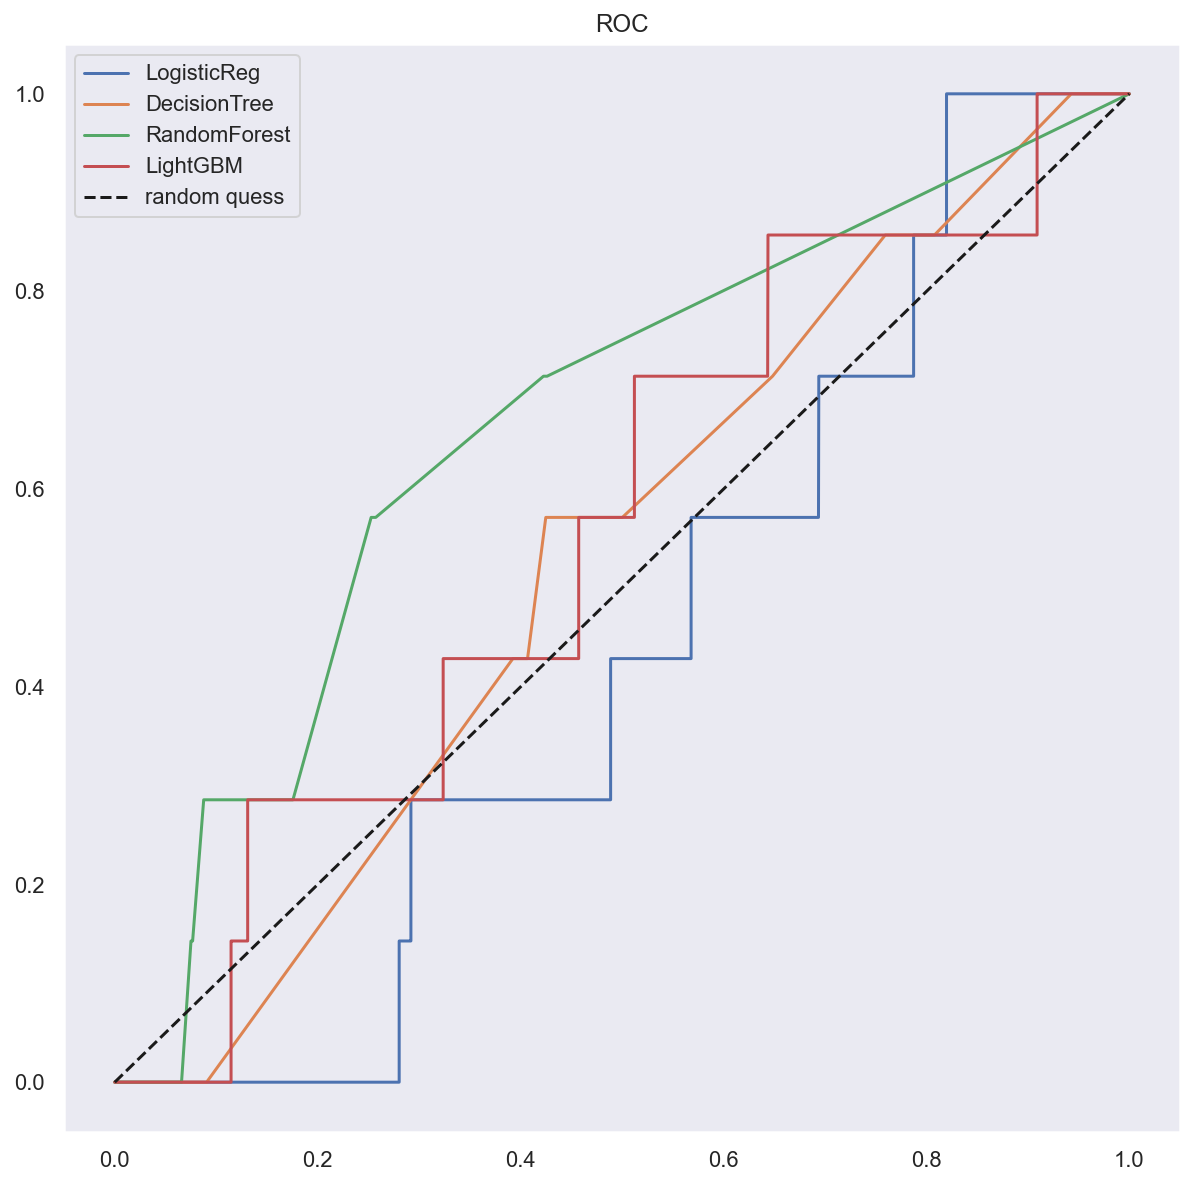

In [38]:
fit_model(models, model_names, X_train_over_d, y_train_over, X_test_d, y_test)

# ==> try-4
drop feature : 'c_24' , 'c_23', 'c_22', 'c_15', 'c_16' \
sampling : SMOTE \

## 1. 전처리

### 1-1. 이상치 제거

In [ ]:
## None

### 1-2. 차원축소
#### feature selection

In [39]:
df_selected = df.drop(['c_24' , 'c_23', 'c_22', 'c_15', 'c_16'], axis=1)
df_selected.shape

(16000, 20)

#### PCA

In [ ]:
## None

### 1-3. train test split

In [40]:
X_train, X_test, y_train, y_test = split_train_test(df_selected)

get train test split!
y_train :  [[0, 1], [12845, 34]]
y_test : [[0, 1], [3114, 7]]


### 1-3. sampling

In [41]:
from imblearn.over_sampling import SMOTE

In [42]:
SAMPLER = SMOTE(random_state=13)
X_train_over, y_train_over = SAMPLER.fit_resample(X_train, y_train)
np.unique(y_train_over, return_counts=True)

(array([0, 1]), array([12845, 12845]))

In [43]:
X_train.shape, y_train.shape

((12879, 18), (12879,))

In [44]:
X_train_over.shape, y_train_over.shape

((25690, 18), (25690,))

### 1-4. dummy

In [45]:
def dummy_selected(df, X_train, X_test):
    """
    df : df to get_dummies
    X_train : 
    X_test : 
    """
    cat_features = ['c_2', 'c_3', 'c_4',
           'c_7', 'c_9', 'c_12','c_13', 'c_14',
           'c_17', 'c_21', 'c_22', 'c_23',
           'c_24']

    dum_features = [feature for feature in cat_features if feature in list(df.columns)]

    X_train_dummy, X_test_dummy = dummy_train_test(X_train, X_test, features=dum_features)
    return X_train_dummy, X_test_dummy

In [46]:
X_train_over_d, X_test_d = dummy_selected(df_selected, X_train_over, X_test)

get dummies!
X_train :  (25690, 53)
X_test :  (3121, 53)


## 2. 학습

### 2-1. model
- Logistic Regression
- Decision Tree
- Random Forest
- LightGBM

### 2-2. 성능평가
- get_clf_eval
- print_clf_eval
- get_result
- get_result_pd

### 2-3. 학습

Finish fitting!
Fit time : 2.515845775604248
<Results>
              accuracy  precision    recall       f1   roc_auc
LogisticReg   0.852291   0.000000  0.000000  0.00000  0.427103
DecisionTree  0.607177   0.002449  0.428571  0.00487  0.518075
RandomForest  0.995194   0.000000  0.000000  0.00000  0.498715
LightGBM      0.993592   0.000000  0.000000  0.00000  0.497913


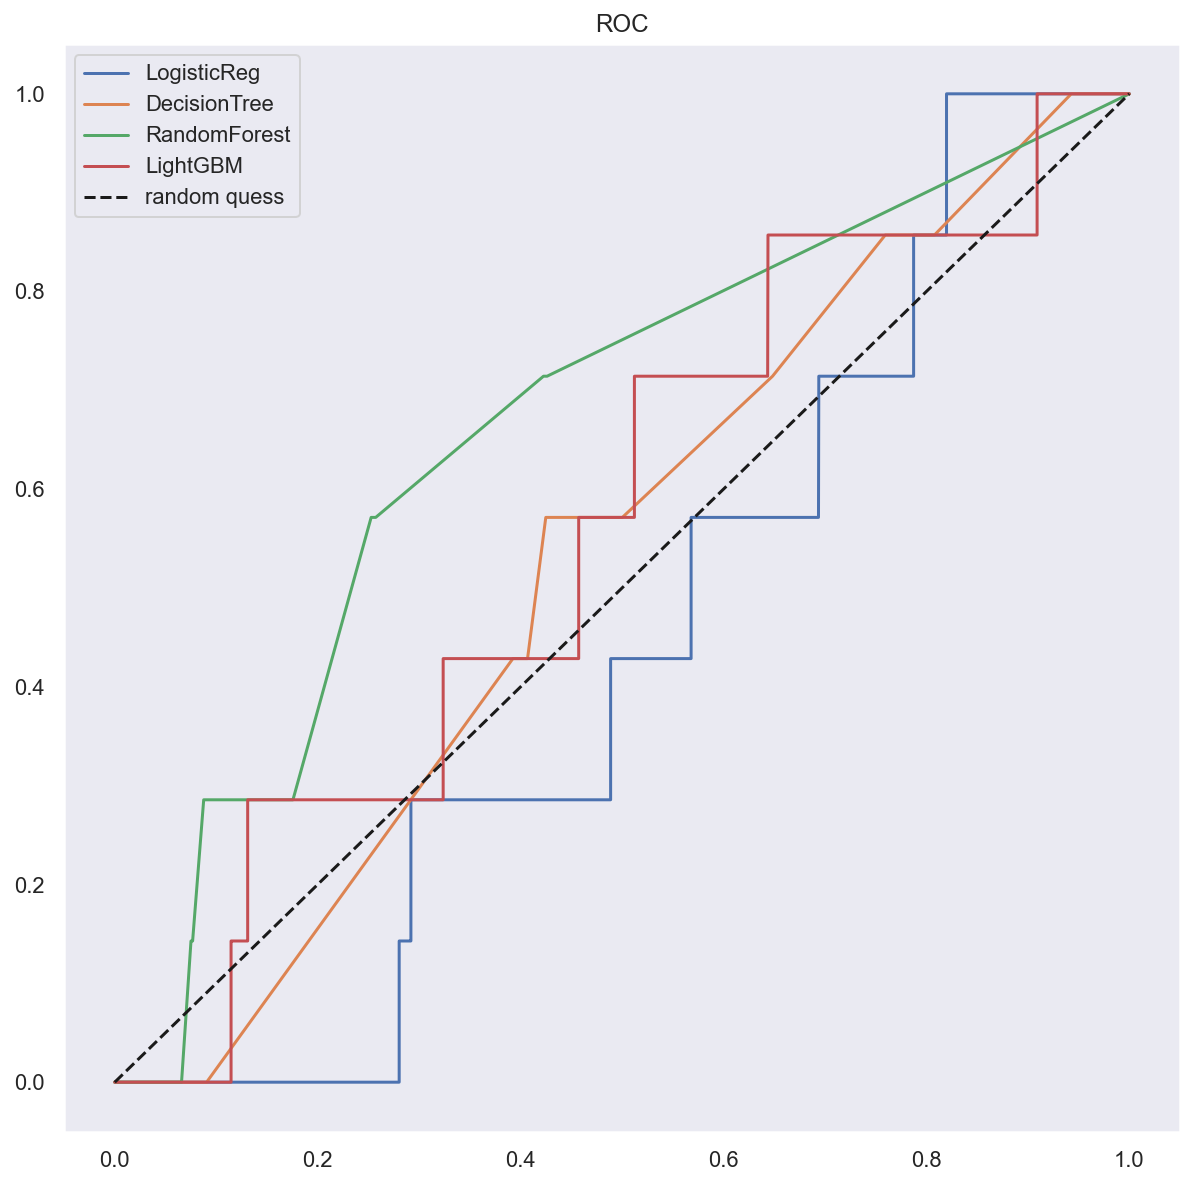

In [47]:
fit_model(models, model_names, X_train_over_d, y_train_over, X_test_d, y_test)

PCA : 'c_12' , 'c_13', 'c_2'